In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [26]:
df = pd.read_csv('/content/after_feature_selection.csv')

In [27]:
df.columns

Index(['price', 'brand', 'utility', 'weight', 'warranty', 'display_size',
       'ppi', 'touch_screen', 'ram', 'ssd', 'graphic', 'core', 'hdmi',
       'backlit_keyboard', 'battery_capacity', 'pixel_height', 'processor'],
      dtype='object')

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
quantiles=df["ppi"].quantile([0.05,0.10,0.25,0.40,0.5,0.65,0.75,0.95])
quantiles

0.05    127.0
0.10    141.0
0.25    141.0
0.40    141.0
0.50    141.0
0.65    157.0
0.75    157.0
0.95    250.0
Name: ppi, dtype: float64

- low->141
- medium->157
- high->250
- verry_high->250<

In [30]:
for i in df["ppi"]:
  if i<=141:
    df["ppi"].replace(i,"low",inplace=True)
  elif i<=157:
    df["ppi"].replace(i,"medium",inplace=True)
  elif i<=250:
    df["ppi"].replace(i,"high",inplace=True)
  else:
    df["ppi"].replace(i,"very_high",inplace=True)

In [31]:
df["ppi"].value_counts()

ppi
low          447
medium       156
high         156
very_high     39
Name: count, dtype: int64

<Axes: xlabel='ppi', ylabel='Count'>

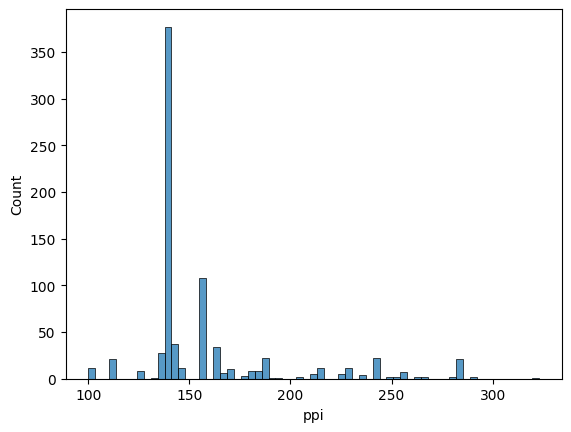

In [11]:
sns.histplot(df["ppi"])

In [32]:
df["brand"]=df["brand"].apply(lambda x:x if df["brand"].value_counts()[x]>4 else "others")

In [33]:
df["processor"]=df["processor"].apply(lambda x:x if df["processor"].value_counts()[x]>6 else "others")

In [34]:
X = df.drop(columns=['price'])
y = df['price']

In [35]:
y_transformed = np.log1p(y)

# Ordinal Encoding

In [10]:
columns_to_encode=["brand","utility","weight","display_size","graphic","core","battery_capacity","processor"]

In [17]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["ppi","ram","ssd","pixel_height"]),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode)
    ],
    remainder='passthrough'
)

In [18]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [19]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [20]:
scores.mean(),scores.std()

(0.8037016695816617, 0.03827556812085876)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [22]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ppi', 'ram', 'ssd',
                                                   'pixel_height']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['brand', 'utility', 'weight',
                                                   'display_size', 'graphic',
                                                   'core', 'battery_capacity',
                                                   'processor'])])),
                ('regressor', LinearRegression())])

In [23]:
y_pred = pipeline.predict(X_test)

In [24]:
y_pred = np.expm1(y_pred)

In [25]:
mean_absolute_error(np.expm1(y_test),y_pred)

14739.337916577933

In [26]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [44]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [45]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [46]:
model_output

[['linear_reg', 0.8037016695816617, 14739.337916577933],
 ['svr', 0.82992665289662, 14783.52453843654],
 ['ridge', 0.8037964419808725, 14730.049477611052],
 ['LASSO', -0.015185282727450688, 30738.576708804576],
 ['decision tree', 0.7960247766545756, 16092.806021906139],
 ['random forest', 0.8759683954540959, 13723.646687320937],
 ['extra trees', 0.8629661630138358, 13078.953631350989],
 ['gradient boosting', 0.8935211799437937, 13340.06615478647],
 ['adaboost', 0.8076664850604555, 15102.52776571181],
 ['xgboost', 0.8876442209780737, 13303.378228759762]]

In [47]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [48]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.862966,13078.953631
9,xgboost,0.887644,13303.378229
7,gradient boosting,0.893521,13340.066155
5,random forest,0.875968,13723.646687
2,ridge,0.803796,14730.049478
0,linear_reg,0.803702,14739.337917
1,svr,0.829927,14783.524538
8,adaboost,0.807666,15102.527766
4,decision tree,0.796025,16092.806022
3,LASSO,-0.015185,30738.576709


# One Hot Encoding

In [49]:
df.columns

Index(['price', 'brand', 'utility', 'weight', 'warranty', 'display_size',
       'ppi', 'touch_screen', 'ram', 'ssd', 'graphic', 'core', 'hdmi',
       'backlit_keyboard', 'battery_capacity', 'pixel_height', 'processor'],
      dtype='object')

In [50]:
columns_to_encode=["weight","display_size","core","battery_capacity","warranty"]

In [54]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["ppi","ram","ssd","pixel_height"]),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',handle_unknown="ignore"),["brand","utility","graphic","processor"])
    ],
    remainder='passthrough'
)

In [55]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [56]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown ca

In [57]:
scores.mean()

0.8880781045499401

In [58]:
scores.std()

0.02392575910298739

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [60]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ppi', 'ram', 'ssd',
                                                   'pixel_height']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['weight', 'display_size',
                                                   'core', 'battery_capacity',
                                                   'warranty']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'utility',
                                                   'graphic', 'processor'])])),
                ('regressor', LinearRegression())])

In [62]:
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
y_pred = np.expm1(y_pred)

In [64]:
mean_absolute_error(np.expm1(y_test),y_pred)

12320.643092698467

In [65]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [66]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [67]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown ca

In [68]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [69]:
model_df.sort_values(['mae'])

,name,r2,mae
1,svr,0.885927,11432.777888
0,linear_reg,0.888078,12320.643093
2,ridge,0.893648,12530.267552
9,xgboost,0.893660,12803.043445
5,random forest,0.883607,13005.883838
6,extra trees,0.867545,13106.502070
7,gradient boosting,0.888673,13161.448398
4,decision tree,0.801034,14994.357072
8,adaboost,0.811965,16446.739752
3,LASSO,-0.015592,30738.576709


# Target Encoding

In [74]:
import category_encoders as ce

In [75]:
columns_to_encode=["weight","display_size","core","battery_capacity","warranty"]

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["ppi","ram","ssd","pixel_height"]),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',handle_unknown="ignore"),["brand","utility","graphic"]),
        ('target_enc', ce.TargetEncoder(), ["processor"])

    ],
    remainder='passthrough'
)

In [77]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [78]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categ

In [79]:
scores.mean(),scores.std()

(0.85359451015545, 0.037392585705550326)

In [80]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [81]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [82]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categ

In [83]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [84]:
model_df.sort_values(['mae'])

,name,r2,mae
0,linear_reg,0.853595,12397.735733
2,ridge,0.870186,12735.691511
5,random forest,0.865883,13131.403875
9,xgboost,0.881367,13304.591785
7,gradient boosting,0.883134,13498.392028
6,extra trees,0.871594,13519.031487
1,svr,0.847422,13672.925016
8,adaboost,0.816378,16136.415091
4,decision tree,0.778774,16845.387861
3,LASSO,-0.015592,30738.576709


# Hyperparameter Tuning

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {
    'svr__C': [1, 10, 100],  # Start with slightly higher values for C
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale', 'auto']
}

In [38]:
columns_to_encode=["weight","display_size","battery_capacity","ppi"]

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["ram","ssd","pixel_height","core","warranty"]),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),["brand","utility","graphic","processor"])
    ],
    remainder='passthrough'
)

In [40]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

In [41]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [42]:
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [43]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ram',
                                                                          'ssd',
                                                                          'pixel_height',
                                                                          'core',
                                                                          'warranty']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['weight',
                                                                          'display_size',
                                                                          'battery_capacity',
                                                                          'ppi']),
                                                                        ('cat1',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['brand',
                                                                          'utility',
                                                                          'graphic',
                                                                          'processor'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='r2', verbose=4)

In [44]:
final_pipe = search.best_estimator_

In [45]:
search.best_score_

0.910671404952193

In [46]:
search.best_params_


{'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}

In [48]:
final_pipe.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ram', 'ssd', 'pixel_height',
                                                   'core', 'warranty']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['weight', 'display_size',
                                                   'battery_capacity', 'ppi']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['brand', 'utility',
                                                   'graphic', 'processor'])])),
                ('svr', SVR(C=10, gamma='auto'))])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [72]:
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error

# Predictions on the test set
y_pred = final_pipe.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test R^2:", r2)
print("Test MAE:", mae)


Test MSE: 0.01337332622424379
Test R^2: 0.951591993322548
Test MAE: 0.08837319694695414


In [51]:
import joblib

# Save the model
joblib.dump(final_pipe, 'best_svr_model.pkl')


['best_svr_model.pkl']

In [81]:
X["utility"].value_counts()

,count
utility,
Performance,357
Everyday Use,208
Gaming,174
Business,59


In [52]:
df.head()

,price,brand,utility,weight,warranty,display_size,ppi,touch_screen,ram,ssd,graphic,core,hdmi,backlit_keyboard,battery_capacity,pixel_height,processor
0,25990.0,Acer,Everyday Use,lite,1.0,small,medium,0,8,512,Integrated,2.0,1,0,medium,1080.0,Intel i3 11.0
1,34990.0,others,Business,medium,1.0,medium,low,0,8,512,Integrated,4.0,1,1,low,1920.0,Intel i5 11.0
2,49990.0,MSI,Performance,medium,2.0,medium,low,0,16,512,Integrated,8.0,1,1,medium,1080.0,Intel i5 12.0
3,79745.0,Acer,Gaming,heavy,1.0,medium,low,0,8,512,NVIDIA,8.0,1,1,medium,1080.0,Intel i5 13.0
4,35990.0,Acer,Performance,medium,1.0,medium,low,0,16,512,Integrated,6.0,1,0,low,1080.0,AMD 5 5.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             798 non-null    float64
 1   brand             798 non-null    object 
 2   utility           798 non-null    object 
 3   weight            798 non-null    object 
 4   warranty          798 non-null    float64
 5   display_size      798 non-null    object 
 6   ppi               798 non-null    object 
 7   touch_screen      798 non-null    int64  
 8   ram               798 non-null    int64  
 9   ssd               798 non-null    int64  
 10  graphic           798 non-null    object 
 11  core              798 non-null    float64
 12  hdmi              798 non-null    int64  
 13  backlit_keyboard  798 non-null    int64  
 14  battery_capacity  798 non-null    object 
 15  pixel_height      798 non-null    float64
 16  processor         798 non-null    object 
dt

In [66]:
data=[["Lenovo","Business","lite",2,"small","medium",0,16,1024,"NVIDIA",8,1,1,"medium",1080,"Intel i5 11.0"]]

In [67]:
columns=['brand', 'utility', 'weight', 'warranty', 'display_size', 'ppi',
       'touch_screen', 'ram', 'ssd', 'graphic', 'core', 'hdmi',
       'backlit_keyboard', 'battery_capacity', 'pixel_height', 'processor']

In [68]:
one_df = pd.DataFrame(data, columns=columns)

one_df

,brand,utility,weight,warranty,display_size,ppi,touch_screen,ram,ssd,graphic,core,hdmi,backlit_keyboard,battery_capacity,pixel_height,processor
0,Lenovo,Business,lite,2,small,medium,0,16,1024,NVIDIA,8,1,1,medium,1080,Intel i5 11.0


In [69]:
# Load the model
loaded_model = joblib.load('best_svr_model.pkl')

# Predict on new data
new_predictions = loaded_model.predict(one_df)


In [70]:
np.expm1(new_predictions)

array([101472.89020642])